# Deep Learning with Natural Language Processing on the Yelp reviews dataset

## Reading in some Yelp reviews

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
%matplotlib inline

In [19]:
# read in the reviews into a DataFrame
yelp = pd.read_csv("yelp_reviews.csv")

In [20]:
print(yelp.shape)
#Looking into the dataset
yelp.head()

#Value counts of 'stars'

yelp['stars'].value_counts()



(1000000, 4)


5    432637
4    229402
1    140308
3    114052
2     83601
Name: stars, dtype: int64

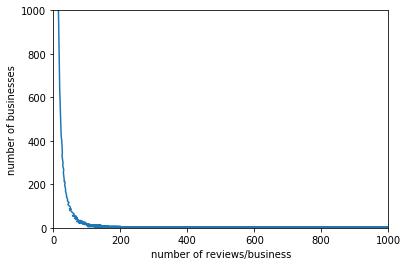

In [21]:
#Figuring out the number of reviews that businesses receive
number_of_reviews = yelp.business_id.value_counts().value_counts().plot()
sns.mpl.pyplot.xlabel("number of reviews/business")
sns.mpl.pyplot.ylabel("number of businesses")
sns.mpl.pyplot.xlim(0,1000)
sns.mpl.pyplot.ylim(0,1000)
sns.mpl.pyplot.show()

#Most businesses have very few reviews. 

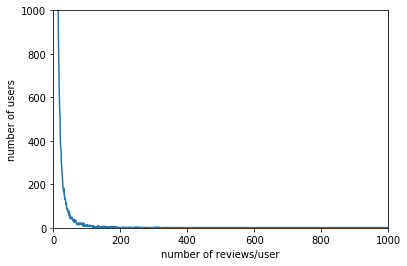

In [22]:
#reviews per user
yelp.user_id.value_counts().value_counts().sort_index().plot()
sns.mpl.pyplot.xlabel("number of reviews/user")
sns.mpl.pyplot.ylabel("number of users")
sns.mpl.pyplot.xlim(0,1000)
sns.mpl.pyplot.ylim(0,1000)
sns.mpl.pyplot.show()

#Both these graphs seem to denote a power law relationship. I plot a log-log plot as the next step

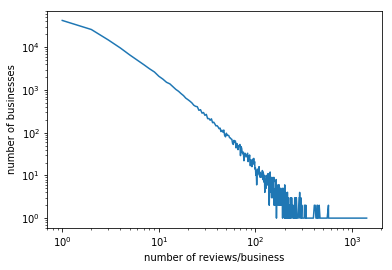

In [23]:
#reviews per business
yelp.business_id.value_counts().value_counts().sort_index().plot(loglog=True)
sns.mpl.pyplot.xlabel("number of reviews/business")
sns.mpl.pyplot.ylabel("number of businesses")
sns.mpl.pyplot.show()

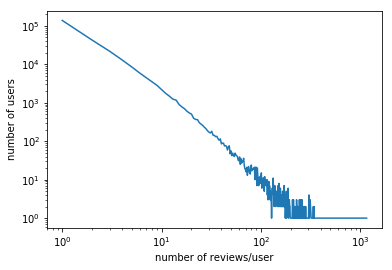

In [24]:
#reviews per user
yelp.user_id.value_counts().value_counts().sort_index().plot(loglog=True)
sns.mpl.pyplot.xlabel("number of reviews/user")
sns.mpl.pyplot.ylabel("number of users")
sns.mpl.pyplot.show()

In [25]:
#To retain meaningful data, we can only look at businesses with > 10 reviews and users with > 10 reviews
#Converting to DataFrame
yelp = pd.DataFrame(yelp)

yelp_smaller = yelp


In [26]:
#keep only businesses with > 10 reviews, users with > 10 reviews
yelp_smaller = yelp.groupby("business_id").filter(lambda x: x.shape[0]>10)
yelp_smaller = yelp_smaller.groupby("user_id").filter(lambda x: x.shape[0]>10)
#and only the 5-star and <=1 star reviews
yelp_smaller = yelp_smaller[(yelp_smaller.stars==5) | (yelp_smaller.stars==1)]
#keep only columns we would want to use later

yelp_smaller["target"] = (yelp_smaller.stars >1).astype(int)
print(yelp_smaller.target.value_counts())

yelp_smaller.reset_index(drop=True,inplace=True)

yelp_smaller.head()

1    95129
0    18562
Name: target, dtype: int64


,business_id,stars,text,user_id,target
0,Aov96CM4FZAXeZvKtsStdA,5,This place is awesome! Definitely authentic!!!...,u0LXt3Uea_GidxRW1xcsfg,1
1,zgQHtqX0gqMw1nlBZl2VnQ,1,really excited to hear of this restaurant comi...,u0LXt3Uea_GidxRW1xcsfg,0
2,hjk3ox7w1akbEuOgTJ03Bw,1,Food is very bland - not authentic at all.\n\n...,u0LXt3Uea_GidxRW1xcsfg,0
3,tOhRQqiupLyJdBJVQMGOEQ,5,OMG - Definitely worth going if you are in Mon...,u0LXt3Uea_GidxRW1xcsfg,1
4,I8rveLd-dl81u6c8YqAxmw,1,If you have not yet tried Wasabi - don't bothe...,u0LXt3Uea_GidxRW1xcsfg,0


- **corpus:** collection of documents
- **corpora:** plural form of corpus

Using StratifiedShuffleSplit to preserve imbalance in the target data

In [27]:
# split the new DataFrame into training and testing sets, keeping relative frequencies of targets unchanged
splitter = StratifiedShuffleSplit(n_splits=2, test_size=0.4,random_state=1)
train_indices,test_indices=list(splitter.split(yelp_smaller.text,yelp_smaller.target))[0]
X_train,y_train = yelp_smaller.text.iloc[train_indices],yelp_smaller.target.iloc[train_indices]
X_test,y_test = yelp_smaller.text.iloc[test_indices],yelp_smaller.target.iloc[test_indices]

In [28]:
y_train.value_counts()/y_train.shape[0]

1    0.873128
0    0.126872
Name: target, dtype: float64

In [29]:
y_test.value_counts()/y_test.shape[0]

1    0.720749
0    0.279251
Name: target, dtype: float64

## Tokenization

In [30]:
# use CountVectorizer to create document-term matrices from X_train and X_test
vect = CountVectorizer(lowercase=False)
train_dtm = vect.fit_transform(X_train)
test_dtm = vect.transform(X_test)

MemoryError: 

In [14]:
# rows are documents, columns are features
train_dtm.shape

(99158, 109198)

In [15]:
# last 50 features
print(vect.get_feature_names()[50:500])

['05a', '05am', '05p', '05pm', '06', '0600', '0601', '0630', '06pm', '07', '0700', '0716', '0730', '074', '0745hrs', '0757', '0777', '079', '07pm', '08', '0800hrs', '0830', '0835', '0840', '0845', '08am', '09', '090', '0900', '0905', '0908', '091', '0912', '094', '09am', '09pm', '0OqUYIsQ', '0P', '0_0', '0admission', '0f', '0h', '0ur', '0ut', '0utta', '0z', '10', '100', '1000', '10000', '100000', '1000000', '100000000000', '100000000000000000000000000000000000000000000', '10000000X', '10000degrees', '1000X', '1000npm', '1000s', '1000x', '1001', '100111fa_fact_seabrook', '1003rd', '1008', '100F', '100Fs', '100K', '100ft', '100g', '100ish', '100k', '100km', '100lbs', '100mbps', '100mg', '100ml', '100mm', '100oz', '100percent', '100pp', '100s', '100th', '100x', '101', '1012', '10127', '1015', '10159531', '101st', '102', '1023', '1024GB', '1026', '1029', '103', '1030', '1030am', '1030ish', '1030pm', '10345', '103rd', '104', '1040', '10420', '1045', '1045a', '1045pm', '105', '1050', '1055',

In [16]:
# show vectorizer options
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

We do not change the text to lowercase because uppercase reviews might actually convey meaning in this case

In [17]:
# allow tokens of one character
vect = CountVectorizer(token_pattern=r'(?u)\b\w+\b', lowercase= False)
train_dtm = vect.fit_transform(X_train)
test_dtm = vect.fit_transform(X_test)
train_dtm.shape

(99158, 109282)

In [18]:
# last 50 features
print(vect.get_feature_names()[-50:])

['yikes', 'yo', 'yogurt', 'yoke', 'yolk', 'yolks', 'york', 'yorkies', 'you', 'young', 'younger', 'youngest', 'your', 'youre', 'yours', 'yourself', 'yourselves', 'youtube', 'yr', 'yrs', 'yuck', 'yucky', 'yum', 'yumminess', 'yummy', 'yup', 'yuppies', 'yuppy', 'zactly', 'zealous', 'zero', 'ziemliches', 'zinged', 'zinger', 'zip', 'ziplock', 'ziti', 'zocalo', 'zombie', 'zombies', 'zone', 'zoned', 'zoning', 'zoo', 'zoom', 'zucchini', 'zupas', 'zwar', 'área', 'überhaupt']


**Predicting 5(positive) vs. 1(negative) star rating:**

In [19]:
# # use default options for CountVectorizer
# vect = CountVectorizer(lowercase = False)

vect = CountVectorizer(lowercase=False)
train_dtm = vect.fit_transform(X_train)
test_dtm = vect.transform(X_test)

lr = LogisticRegression()
lr.fit(train_dtm, y_train)
y_pred_class = lr.predict(test_dtm)
print(metrics.accuracy_score(y_test, y_pred_class))



0.8874133949191686


In [20]:
# calculate null accuracy
y_test.mean()

0.0

Just using raw counts of different words gives us very good performance!

Let's examine the most positive and most negative words (their coefficients will tell us whether they are most indicative of a positive or negative review).

In [21]:
feature_coeffs = pd.DataFrame(list(zip(vect.get_feature_names(),lr.coef_[0])),columns=["word","coeff"])
feature_coeffs = feature_coeffs.sort_values(by="coeff",ascending=False).reset_index(drop=True)

Words most indicative of positive review:

In [22]:
feature_coeffs.head()

,word,coeff
0,Excellent,2.964825
1,excellent,2.787336
2,Love,2.598844
3,Amazing,2.454324
4,perfect,2.407325


Words most indicative of negative review:

In [23]:
feature_coeffs.tail()

,word,coeff
109193,rude,-2.735447
109194,bland,-2.742936
109195,Worst,-2.912159
109196,poisoning,-3.400705
109197,worst,-3.440507


In [24]:
feature_coeffs["abs_coeff"] = feature_coeffs.coeff.abs()

Most predictive words, regardless of polarity:

In [25]:
feature_coeffs.sort_values(by="abs_coeff",inplace=True,ascending=False)
feature_coeffs.head(100)

,word,coeff,abs_coeff
109197,worst,-3.440507,3.440507
109196,poisoning,-3.400705,3.400705
0,Excellent,2.964825,2.964825
109195,Worst,-2.912159,2.912159
1,excellent,2.787336,2.787336
109194,bland,-2.742936,2.742936
109193,rude,-2.735447,2.735447
2,Love,2.598844,2.598844
109192,disappointing,-2.565074,2.565074
109191,stale,-2.515708,2.515708


Useless words (dont tell you anything about the polarity of the review):

In [26]:
feature_coeffs.tail(20)

,word,coeff,abs_coeff
80030,magnetized,3.125496e-10,3.125496e-10
80051,Quiznoes,-2.742999e-10,2.742999e-10
80049,Miscellaneous,-2.656424e-10,2.656424e-10
80047,Caballo,-2.656424e-10,2.656424e-10
80048,Montañera,-2.656424e-10,2.656424e-10
80050,hogado,-2.656424e-10,2.656424e-10
80033,Pashley,1.789651e-10,1.789651e-10
80034,tapanade,1.233110e-10,1.233110e-10
80046,mircro,-1.002039e-10,1.002039e-10
80045,Clandestine,-9.795348e-11,9.795348e-11


In [27]:
feature_coeffs.head()

,word,coeff,abs_coeff
109197,worst,-3.440507,3.440507
109196,poisoning,-3.400705,3.400705
0,Excellent,2.964825,2.964825
109195,Worst,-2.912159,2.912159
1,excellent,2.787336,2.787336


## Pipelines To Make CV/Transformations Easier With Imbalanced Data

In [28]:
#Building pipelines here for transformations

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [29]:
#Considering a subset of features to make processing faster    
yelp_pipeline = Pipeline([("countVect", CountVectorizer(max_features = 1000)),("logreg", LogisticRegression())])

In [30]:
strat_cv = StratifiedKFold(n_splits=2)

In [31]:
np.mean(cross_val_score(yelp_pipeline,
                yelp_smaller.text,
                yelp_smaller.target,
                scoring="accuracy",
                cv=strat_cv,
                n_jobs=-1,
                verbose=1))

[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   46.8s finished


0.9624156638118878

In [32]:
yelp_pipeline.fit(yelp_smaller.text,yelp_smaller.target)

Pipeline(memory=None,
     steps=[('countVect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [33]:
# Creating a function that accepts a vectorizer and returns a table with the coefficients and accuracy of cv-ed model
def tokenize_test(vect):
    pipe = Pipeline([("vect",vect),("lr",LogisticRegression())])
    pipe.fit(yelp_smaller.text,yelp_smaller.target)
    num_features = len(pipe.steps[0][1].get_feature_names())
    print('Num Features: ', num_features)

    zipped_coeffs = list(zip(pipe.steps[0][1].get_feature_names(),
                             pipe.steps[1][1].coef_[0]))
    feature_coeffs = pd.DataFrame(zipped_coeffs,columns=["word","coeff"]).sort_values(by="coeff",ascending=False)
    feature_coeffs.reset_index(drop=True,inplace=True)

    strat_cv = StratifiedKFold(n_splits=2)
    acc = np.mean(cross_val_score(pipe,
                yelp_smaller.text,
                yelp_smaller.target,
                scoring="accuracy",
                cv=strat_cv,
                n_jobs=-1,
                verbose=1))
    print("Accuracy:", acc)
    return (feature_coeffs, acc)

In [34]:
# We can customize this vec as we want
vect = CountVectorizer(max_features=1000)
feature_coeffs,acc = tokenize_test(vect)

Num Features:  1000
Accuracy: 0.9624156638118878


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   46.0s finished


In [35]:
feature_coeffs.head(10)

,word,coeff
0,perfection,3.142748
1,excellent,2.518639
2,incredible,2.454513
3,delicious,2.364826
4,perfect,2.263292
5,fantastic,2.164809
6,amazing,2.159500
7,awesome,2.135797
8,favorites,2.039298
9,outstanding,1.998869


In [36]:
feature_coeffs.sort_values("coeff").head(10)

,word,coeff
999,worst,-3.415490
998,bland,-2.805640
997,terrible,-2.641418
996,horrible,-2.565443
995,rude,-2.414776
994,poor,-2.030622
993,unfortunately,-1.789316
992,dirty,-1.546174
991,sorry,-1.490507
990,tasted,-1.272886


## Stopword Removal

In [37]:
# show vectorizer options
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [38]:
# remove English stop words
vect = CountVectorizer(stop_words='english',max_features=1000, min_df=0.005, max_df = 0.7)
feature_coeffs,acc = tokenize_test(vect)

Num Features:  1000
Accuracy: 0.957789092910986


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   37.5s finished


In [39]:
feature_coeffs.head(10)

,word,coeff
0,perfection,3.526148
1,incredible,2.572324
2,excellent,2.571913
3,phenomenal,2.459257
4,delicious,2.403472
5,delish,2.284492
6,fantastic,2.216050
7,amazing,2.188376
8,awesome,2.170381
9,notch,2.162207


In [40]:
feature_coeffs.tail(10).sort_values("coeff")

,word,coeff
999,worst,-3.425821
998,bland,-2.772050
997,horrible,-2.671436
996,awful,-2.648629
995,terrible,-2.633795
994,rude,-2.358765
993,waste,-2.278950
992,poor,-2.092000
991,unfortunately,-1.832402
990,dirty,-1.599713


In [41]:
# set of stop words
print(vect.get_stop_words())

frozenset({'too', 'sometimes', 'whereas', 'forty', 'because', 'ie', 'most', 'seem', 'found', 'always', 'my', 'became', 'once', 'without', 'take', 'behind', 'anyone', 'nobody', 'hasnt', 'former', 'less', 'un', 'fill', 'never', 'more', 'least', 'seeming', 'then', 'bottom', 'ten', 'anywhere', 'find', 'upon', 'rather', 'beside', 'it', 'under', 'whatever', 'whoever', 'still', 'could', 'nevertheless', 'they', 'why', 'such', 'moreover', 'even', 'over', 'since', 'around', 'for', 'mine', 'six', 'wherever', 'herein', 'do', 'yourself', 'a', 'somehow', 'nine', 'someone', 'five', 'your', 'ours', 'and', 'him', 'done', 'part', 'hence', 'few', 'these', 'move', 'would', 'fire', 're', 'anyhow', 'latterly', 'we', 'first', 'somewhere', 'the', 'therein', 'everywhere', 'other', 'whereby', 'thence', 'noone', 'an', 'everyone', 'seems', 'whence', 'with', 'within', 'three', 'has', 'many', 'among', 'describe', 'whether', 'co', 'now', 'this', 'was', 'while', 'you', 'during', 'via', 'although', 'its', 'very', 'eg'

## Other CountVectorizer Options

In [42]:
# remove English stop words and only keep words appearing in 0.5% of documents
vect = CountVectorizer(stop_words='english', min_df = 0.005)
features,acc = tokenize_test(vect)

Num Features:  1581
Accuracy: 0.9623716918424552


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   38.6s finished


In [43]:
features.head()

,word,coeff
0,perfection,3.163696
1,incredible,2.679297
2,phenomenal,2.606023
3,excellent,2.605894
4,pleasantly,2.485137


In [44]:
features.sort_values("coeff").head()

,word,coeff
1580,worst,-3.420313
1579,disappointing,-2.992058
1578,disappointment,-2.850296
1577,disgusting,-2.719061
1576,horrible,-2.676040


In [49]:
features.head()

,word,coeff
0,perfection,3.163696
1,incredible,2.679297
2,phenomenal,2.606023
3,excellent,2.605894
4,pleasantly,2.485137


In [50]:
features.sort_values("coeff").head()

,word,coeff
1580,worst,-3.420313
1579,disappointing,-2.992058
1578,disappointment,-2.850296
1577,disgusting,-2.719061
1576,horrible,-2.676040


## Using TF-IDF to Summarize a Yelp Review


In [51]:
# create a document-term matrix using TF-IDF
vect = TfidfVectorizer(stop_words='english')
dtm = vect.fit_transform(yelp_smaller.text)
features = vect.get_feature_names()
dtm.shape


(113691, 87434)

In [53]:
from textblob import TextBlob
def summarize():
    
    # choose a random review that is at least 500 characters
    review_length = 0
    while review_length < 500:
        review_id = np.random.randint(0, len(yelp_smaller))
        review_text = yelp_smaller.text.iloc[review_id]
        review_length = len(review_text)
    
    # create a dictionary of words and their TF-IDF scores
    word_scores = {}
    for word in TextBlob(review_text).words:
        word = word.lower()
        if word in features:
            word_scores[word] = dtm[review_id, features.index(word)]
    
    # print words with the top 5 TF-IDF scores
    print('TOP SCORING WORDS:')
    top_scores = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:5]
    for word, score in top_scores:
        print(word)
    
    # print 5 random words
    print('\n' + 'RANDOM WORDS:')
    random_words = np.random.choice(list(word_scores.keys()), size=5, replace=False)
    for word in random_words:
        print(word)
    
    # print the review
    print('\n' + review_text)

In [54]:
summarize()

TOP SCORING WORDS:
cioccolatta
panino
godly
porchetta
darren

RANDOM WORDS:
torta
boss
apple
home
time

Our boss treated some co-workers and myself to lunch here last week (one of my colleagues was leaving) and had a terrific time. The decor is amazing and so is the food. I had the Porchetta panino (pulled pork Shoulder with horseradish apple salsa) which came with these parsely-seasoned home fries. All of it was amazing. Like Darren (I was so jealous he got to go there back in February and I didn't), I had the Torta di Cioccolatta, and it was godly. The service was on-target too. I love this place and that it's so close to where I now work. Seriously gourmet.


## Stemming and Lemmatization

In [55]:
# initialize stemmer
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')


review_id = np.random.randint(0, len(yelp_smaller))
review = TextBlob(yelp_smaller.text.iloc[review_id])

# stem each word
print([stemmer.stem(word) for word in review.words])

['bad', 'design', 'poor', 'signag', 'bad', 'attitud', 'from', 'employe', 'tsa', 'ineffect', 'to', 'the', 'point', 'of', 'danger', 'dirti', 'bathroom', 'horrend', 'access', 'deplor', 'all', 'around']


**Lemmatization**

- **What:** Derive the canonical form ('lemma') of a word
- **Why:** Can be better than stemming
- **Notes:** Uses a dictionary-based approach (slower than stemming)

In [56]:
# assume every word is a noun
print([word.lemmatize() for word in review.words])

['Bad', 'design', 'Poor', 'signage', 'Bad', 'attitude', 'from', 'employee', 'TSA', 'ineffective', 'to', 'the', 'point', 'of', 'danger', 'Dirty', 'bathroom', 'Horrendous', 'accessibility', 'Deplorable', 'all', 'around']


In [ ]:
# assume every word is a verb
print([word.lemmatize(pos='v') for word in review.words])

In [ ]:
# define a function that accepts text and returns a list of lemmas
def split_into_lemmas(text):
    text = text.lower()
    words = TextBlob(text).words
    return [word.lemmatize() for word in words]

In [60]:
# use split_into_lemmas as the feature extraction function
vect = CountVectorizer(analyzer=split_into_lemmas)
features,acc = tokenize_test(vect)

KeyboardInterrupt: 

In [ ]:
features.head()

In [ ]:
features.sort_values("coeff").head()

## Sentiment Analysis

In [61]:
print(review)

Bad design. Poor signage.  Bad attitude from employees.  TSA ineffective to the point of danger.  Dirty bathrooms.  Horrendous accessibility. Deplorable all around.


In [62]:
# polarity ranges from -1 (most negative) to 1 (most positive)
review.sentiment.polarity

-0.6

In [63]:
yelp_smaller['length'] = yelp_smaller.text.apply(len)
#Picking a subset of 250 reviews for sentiment analysis
yelp_smaller_subset = yelp_smaller.iloc[1:250, :]

In [64]:
# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [65]:
# create a new DataFrame column for sentiment
yelp_smaller['sentiment'] = yelp_smaller_subset.text.apply(detect_sentiment)

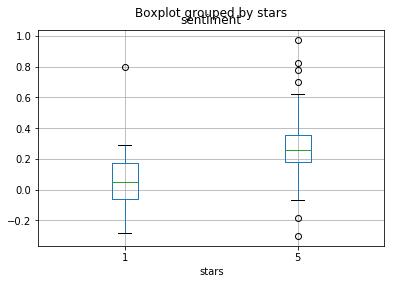

In [66]:
# boxplot of sentiment grouped by stars
yelp_smaller.boxplot(column='sentiment', by='stars')

In [67]:

#Adding the extra feature 'length' to the document term matrix

feature_cols = ['text','length']
X = yelp_smaller[feature_cols]
y = yelp_smaller.target
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [68]:
# use CountVectorizer with text column only
yelp_pipeline = Pipeline([("countVect",CountVectorizer(stop_words="english")),
                     ("lr",LogisticRegression(C=0.1))])
strat_cv = StratifiedKFold(n_splits=2)
text_only_acc = np.mean(cross_val_score(yelp_pipeline,
                        X.text,
                        y,
                        scoring="accuracy",
                        cv=strat_cv,
                        n_jobs=-1,
                        verbose=1))
print("text only accuracy: ",np.round(text_only_acc,4))

KeyboardInterrupt: 

In [ ]:
print("Original matrix: ",CountVectorizer(stop_words="english").fit_transform(X.text).shape)

## Applying Word2vec techniques on the yelp dataset





The methods I have used till now involve frequency embedding techniques. I want to try and improve the accuracy of my sentiment analysis by using contextual embedding techniques on a preprocessed dataset. By preprocessing, I mean removal of stopwords and punctuation and so on. Finally I want to try building a convolutional neural network model with feature extraction using word2vec.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import base64
import string #use for punctuation removal
import re
from collections import Counter
from time import time

#nlp specific libraries
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy
nlp = spacy.load('en')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#For word2vec techniques which are computationally very expensive, I am going to use a smaller subset of the original dataset. 
#This subset contains 20,000 rows of data. It only have reviews with 5 or 1 stars.
yelp = pd.read_csv("yelp_smaller_20k.csv",index_col=0).reset_index(drop=True)
yelp.head()

,business_id,stars,text,user_id
0,8Gi91EkhG2_CJLk_WqjpEg,1,I found them through Craigslist. I did the 2 m...,um0ITBTHoohdozmFA6snlw
1,6zincCvQTb9BsuK-GHZ4cw,5,"Great pizza, excellent delivery time & if I ev...",tNcIhWEeAl607ENbeRSm0w
2,kzANsUYAZFnMsogB1RFE7A,5,Finding an incredible hairstylist is like find...,EJ7ZhRHsMWj8du77LX34gw
3,uBAHE6QOJlndILPIoeEpCQ,1,I attempted to use a coupon for the exact item...,RNVCLdKNddXp8v-y6Aq2Xg
4,yzmvsG3Vo-2_F3_0wHzJdA,1,Dammit! I had such high hopes for this place. ...,D5ETbJC0dptWR07sbTlqRg


In [5]:
print(yelp.stars.value_counts())

print(yelp.stars.value_counts()/len(yelp.stars))

#We can see this dataset is highly imbalanced. We need to deal 

5    15074
1     4926
Name: stars, dtype: int64
5    0.7537
1    0.2463
Name: stars, dtype: float64


In [6]:
#target
yelp["target"] = (yelp.stars == 5).astype(int)

## Text Pre-processing

Below, I perform pre-processing on the text data. The steps include 1) stopword removal 2)lemmatization 3) Removal of punctuation 4) splitting text into sentences. 


In [7]:
# Define function to preprocess text for a word2vec model
def cleanup_text_word2vec(docs, logging=False):
    sentences = []
    counter = 1
    for doc in nlp.pipe(docs,n_threads=4,disable=["tagger"]):
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents" % (counter, len(docs)))
        # Grab lemmatized form of words and make lowercase
        doc = " ".join([tok.lemma_.lower() for tok in doc])
        # Split into sentences based on punctuation - assuming a period, question mark, exclamation point, and apostroper
        # dictate the end of a given sentence.
        doc = re.split("[\.?!;] ", doc)
        # Remove commas, periods, and other punctuation (mostly commas) from each sentence
        doc = [sent.translate(sent.maketrans("","",string.punctuation)) for sent in doc]
        # Split each sentence into distinct words
        doc = [sent.split() for sent in doc]
        sentences += doc
        counter += 1
    return sentences

In [8]:
yelp_cleaned_word2vec = cleanup_text_word2vec(yelp.text, logging=True)

Processed 1000 out of 20000 documents
Processed 2000 out of 20000 documents
Processed 3000 out of 20000 documents
Processed 4000 out of 20000 documents
Processed 5000 out of 20000 documents
Processed 6000 out of 20000 documents
Processed 7000 out of 20000 documents
Processed 8000 out of 20000 documents
Processed 9000 out of 20000 documents
Processed 10000 out of 20000 documents
Processed 11000 out of 20000 documents
Processed 12000 out of 20000 documents
Processed 13000 out of 20000 documents
Processed 14000 out of 20000 documents
Processed 15000 out of 20000 documents
Processed 16000 out of 20000 documents
Processed 17000 out of 20000 documents
Processed 18000 out of 20000 documents
Processed 19000 out of 20000 documents
Processed 20000 out of 20000 documents


In [9]:
#Building a word2vec model

from gensim.models.word2vec import Word2Vec

text_dim = 300


#Using a skip-gram model, so sg = 1
wordvec_model_300 = Word2Vec(yelp_cleaned_word2vec, size=text_dim, window=5, min_count=3, workers=4, sg=1)

print("%d unique words represented by %d dimensional vectors in this model" % (len(wordvec_model_300.wv.vocab), text_dim))

C:\Users\Madhu\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


13794 unique words represented by 300 dimensional vectors in this model


In [10]:
#Looking into the wordtovec model created above

print("Words most similar to cafe:\n",wordvec_model_300.wv.most_similar(positive=['cafe']))

print("Which of the words amazing good awesome bland don\'t match: ",wordvec_model_300.wv.doesnt_match("amazing good awesome bland".split()))
print()

print("Words most similar to restaurant - big:\n",wordvec_model_300.wv.most_similar_cosmul(positive=['restaurant'], negative=["big"]))
print()

print("How related is morning to dinner: ",wordvec_model_300.wv.similarity('morning', 'dinner'))
print()
print("How related is night to dinner: ",wordvec_model_300.wv.similarity('night', 'dinner'))

C:\Users\Madhu\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Words most similar to cafe:
 [('café', 0.7513088583946228), ('bakery', 0.7152332067489624), ('pub', 0.7121677398681641), ('tavern', 0.7121496796607971), ('uptown', 0.6944003701210022), ('theatre', 0.6932998895645142), ('brewery', 0.6894760131835938), ('cabo', 0.6865200400352478), ('eatery', 0.6861717104911804), ('bistro', 0.6799688339233398)]
Which of the words amazing good awesome bland don't match:  bland

Words most similar to restaurant - big:
 [('cuisine', 1.4078543186187744), ('establishment', 1.3695553541183472), ('la', 1.352676510810852), ('salon', 1.328722596168518), ('cafe', 1.3157135248184204), ('place', 1.2921502590179443), ('dealership', 1.2884690761566162), ('property', 1.287079930305481), ('hotel', 1.2846736907958984), ('fitness', 1.2845988273620605)]

How related is morning to dinner:  0.4116895

How related is night to dinner:  0.6540447


## Document classification using Word2vec

For document classification into positive or negative using Word2Vec, I first create a function to compute the average of all the word vectors in a piece of text. After this, I would clean the text in such a way that the information about which reviews each of the sentences belong to is preserved

In [11]:
#Compute average function

def create_average_vec(doc):
    average = np.zeros((text_dim,), dtype = 'float32')
    num_words = 0
    words = doc.split(" ")
    
    for word in words:
        if word in wordvec_model_300.wv.vocab:
            average = np.add(wordvec_model_300[word], average)
            num_words+= 1
    if num_words > 0:
        average = np.divide(average,num_words)
    return average

In [12]:
#Now, we need to re-process the input data such that we retain the indices of each doc. This is so we can apply the create average function on each document in the data

punctuations = string.punctuation

def cleanup_text(docs, logging=True):
    proc_docs = []
    counter = 1
    for doc in nlp.pipe(docs, n_threads=4,disable=["tagger"]):
        if counter % 200 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        tokens = [tok.lemma_.lower().strip() for tok in doc] #lemmatize, remove pronouns #if tok.lemma_ != '-PRON-'
        tokens = [tok for tok in tokens if tok not in stopwords.words() and tok not in punctuations] #remove stopwords, punctuation
        tokens = ' '.join(tokens)
        proc_docs.append(tokens)
    return proc_docs

In [13]:
#Now applying the above function to yelp data. This takes a lot of time to run. So I run it once and now load in the dataset each time

#yelp_smaller_clean = pd.Series(cleanup_text(yelp.text,logging=True))

# LOAD IN THE CLEANED DATA INSTEAD :)
yelp_smaller_clean = pd.read_csv("./yelp_cleaned_word2vec.csv")
yelp_smaller_clean.cleaned_text.fillna("",inplace=True)


In [14]:
#Applying the create average vector of words function to each document here
final_cleaned_vec = np.zeros((yelp_smaller_clean.shape[0], text_dim), dtype="float32")  # 20000 x 300
for i in range(yelp_smaller_clean.shape[0]):
    final_cleaned_vec[i] = create_average_vec(yelp_smaller_clean.cleaned_text.values[i])

print("Final word vector shape:", final_cleaned_vec.shape)
yelp_smaller_clean.head()


C:\Users\Madhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


Final word vector shape: (20000, 300)


,cleaned_text,text,stars,target
0,find craigslist 2 maid 68 dollar two hour firs...,I found them through Craigslist. I did the 2 m...,1,0
1,great pizza excellent delivery time ever back ...,"Great pizza, excellent delivery time & if I ev...",5,1
2,finding incredible hairstylist like find unico...,Finding an incredible hairstylist is like find...,5,1
3,attempt use coupon exact item state picture ma...,I attempted to use a coupon for the exact item...,1,0
4,dammit high hope place -pron- eat month finall...,Dammit! I had such high hopes for this place. ...,1,0


In [15]:
# Now, we can use this 20000*300 vector as an input to a linear model and a non-linear model. Starting off with Logistic regression
#Finding the cross validated score of Logistic regression using Stratified K-Fold
from sklearn.model_selection import cross_val_score,StratifiedKFold
sk = StratifiedKFold(n_splits = 10)

print(np.mean(cross_val_score(LogisticRegression(), final_cleaned_vec, yelp_smaller_clean.target, cv= sk, scoring = "accuracy")))

0.9470494144123537


In [16]:
# Using a Random Forest Classifier, we can see that the accuracy of the simpler(logistic) model is more than the Random Forest

from sklearn.ensemble import RandomForestClassifier

sk = StratifiedKFold(n_splits=3)
np.mean(cross_val_score(RandomForestClassifier(n_estimators=50),
                        final_cleaned_vec,
                        yelp_smaller_clean.target,
                        cv=sk,
                        scoring="accuracy"))

0.9253499146224807

As the last step of this project, we can train an MLP and Convolutional Neural Network Model on the data to see if there is an improvement in the accuracy.

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final_cleaned_vec, yelp_smaller_clean.target, test_size=0.2, random_state=21)

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))
print("y-split train:\n",y_train.value_counts()/y_train.shape[0])
print("y-split test:\n",y_test.value_counts()/y_test.shape[0])

X_train size: (16000, 300)
X_test size: (4000, 300)
y_train size: (16000,)
y_test size: (4000,)
y-split train:
 1    0.75575
0    0.24425
Name: target, dtype: float64
y-split test:
 1    0.7455
0    0.2545
Name: target, dtype: float64


In [18]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import SGD

#Below, I build a Multi Layered Perceptron (Perceptrons with dropout at each step to prevent overfitting followed by sigmoid activation layer) and CNN (Convolution Filter + Relu Activation followed by Max pooling (and maybe dropout)) model followed by sigmoid activation)

def build_deeplearning_model(model_type = "mlp", input_dim = 300):
    model = Sequential()
    if model_type == "mlp":
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=input_dim))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=input_dim))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=input_dim))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=input_dim))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation = 'sigmoid'))
    elif model_type == "cnn":
        inputs = Input(shape=(input_dim,1))
        x = Conv1D(64, 3, strides=1, padding='same', kernel_initializer="uniform",activation='relu')(inputs)
        x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(128, 3, strides=1, padding='same', kernel_initializer="uniform",activation='relu')(x)
        x = GlobalMaxPooling1D()(x) 
        outputs = Dense(1, kernel_initializer="uniform", activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs, name='CNN')
    return model
    

        



C:\Users\Madhu\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [19]:
#Building the model

model = build_deeplearning_model('cnn')

# If the model is a CNN then expand the dimensions of the training data
if model.name == "CNN":
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    print('Text train shape: ', X_train.shape)
    print('Text test shape: ', X_test.shape)
    
model.summary()



Text train shape:  (16000, 300, 1)
Text test shape:  (4000, 300, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 64)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 150, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 150, 128)          24704     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 25,089
Trainable params: 25,089
Non-trainable params: 0
____

In [20]:
# Compile the model
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['acc'])

# Define number of epochs
epochs = 5

# Fit the model to the training data
estimator = model.fit(X_train, y_train,
                      validation_data=(X_test,y_test),
                      epochs=epochs, batch_size=128, verbose=1)

Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 [==============================] - ETA: 8:47 - loss: 0.6931 - acc: 0.601 - ETA: 6:26 - loss: 0.6919 - acc: 0.691 - ETA: 5:53 - loss: 0.6908 - acc: 0.718 - ETA: 5:46 - loss: 0.6903 - acc: 0.712 - ETA: 5:34 - loss: 0.6890 - acc: 0.726 - ETA: 5:32 - loss: 0.6874 - acc: 0.747 - ETA: 5:27 - loss: 0.6865 - acc: 0.745 - ETA: 5:17 - loss: 0.6855 - acc: 0.745 - ETA: 5:09 - loss: 0.6844 - acc: 0.744 - ETA: 4:53 - loss: 0.6831 - acc: 0.746 - ETA: 4:44 - loss: 0.6819 - acc: 0.745 - ETA: 4:35 - loss: 0.6805 - acc: 0.744 - ETA: 4:29 - loss: 0.6784 - acc: 0.748 - ETA: 4:28 - loss: 0.6767 - acc: 0.748 - ETA: 4:23 - loss: 0.6740 - acc: 0.753 - ETA: 4:16 - loss: 0.6721 - acc: 0.752 - ETA: 4:13 - loss: 0.6706 - acc: 0.750 - ETA: 4:06 - loss: 0.6680 - acc: 0.752 - ETA: 4:02 - loss: 0.6655 - acc: 0.752 - ETA: 3:56 - loss: 0.6627 - acc: 0.753 - ETA: 3:53 - loss: 0.6598 - acc: 0.754 - ETA: 3:51 - loss: 0.6558 - acc: 0.757 - ETA: 3:47 - lo

16000/16000 [==============================] - ETA: 3:44 - loss: 0.6048 - acc: 0.710 - ETA: 4:00 - loss: 0.5512 - acc: 0.757 - ETA: 3:58 - loss: 0.5365 - acc: 0.770 - ETA: 3:55 - loss: 0.5529 - acc: 0.755 - ETA: 4:01 - loss: 0.5488 - acc: 0.759 - ETA: 3:59 - loss: 0.5451 - acc: 0.763 - ETA: 3:52 - loss: 0.5562 - acc: 0.753 - ETA: 3:51 - loss: 0.5599 - acc: 0.750 - ETA: 3:49 - loss: 0.5608 - acc: 0.749 - ETA: 3:47 - loss: 0.5571 - acc: 0.752 - ETA: 3:43 - loss: 0.5497 - acc: 0.759 - ETA: 3:41 - loss: 0.5532 - acc: 0.755 - ETA: 3:43 - loss: 0.5496 - acc: 0.759 - ETA: 3:39 - loss: 0.5534 - acc: 0.755 - ETA: 3:35 - loss: 0.5486 - acc: 0.759 - ETA: 3:33 - loss: 0.5514 - acc: 0.757 - ETA: 3:29 - loss: 0.5472 - acc: 0.761 - ETA: 3:28 - loss: 0.5458 - acc: 0.762 - ETA: 3:25 - loss: 0.5437 - acc: 0.764 - ETA: 3:22 - loss: 0.5478 - acc: 0.760 - ETA: 3:19 - loss: 0.5485 - acc: 0.760 - ETA: 3:19 - loss: 0.5477 - acc: 0.760 - ETA: 3:17 - loss: 0.5471 - acc: 0.761 - ETA: 3:14 - loss: 0.5480 - acc: 0

16000/16000 [==============================] - ETA: 4:02 - loss: 0.4725 - acc: 0.828 - ETA: 3:47 - loss: 0.5236 - acc: 0.777 - ETA: 4:01 - loss: 0.5254 - acc: 0.776 - ETA: 4:06 - loss: 0.5478 - acc: 0.753 - ETA: 4:02 - loss: 0.5352 - acc: 0.765 - ETA: 4:04 - loss: 0.5381 - acc: 0.763 - ETA: 3:58 - loss: 0.5420 - acc: 0.758 - ETA: 3:56 - loss: 0.5389 - acc: 0.761 - ETA: 3:52 - loss: 0.5364 - acc: 0.763 - ETA: 3:50 - loss: 0.5422 - acc: 0.758 - ETA: 3:49 - loss: 0.5470 - acc: 0.754 - ETA: 3:48 - loss: 0.5453 - acc: 0.755 - ETA: 3:43 - loss: 0.5444 - acc: 0.756 - ETA: 3:39 - loss: 0.5442 - acc: 0.756 - ETA: 3:38 - loss: 0.5428 - acc: 0.757 - ETA: 3:35 - loss: 0.5414 - acc: 0.759 - ETA: 3:33 - loss: 0.5417 - acc: 0.759 - ETA: 3:29 - loss: 0.5416 - acc: 0.759 - ETA: 3:28 - loss: 0.5438 - acc: 0.757 - ETA: 3:27 - loss: 0.5451 - acc: 0.755 - ETA: 3:25 - loss: 0.5458 - acc: 0.755 - ETA: 3:21 - loss: 0.5443 - acc: 0.756 - ETA: 3:20 - loss: 0.5470 - acc: 0.754 - ETA: 3:18 - loss: 0.5448 - acc: 0

16000/16000 [==============================] - ETA: 4:53 - loss: 0.4516 - acc: 0.828 - ETA: 4:36 - loss: 0.4717 - acc: 0.808 - ETA: 4:07 - loss: 0.5053 - acc: 0.778 - ETA: 3:59 - loss: 0.5090 - acc: 0.773 - ETA: 3:49 - loss: 0.5122 - acc: 0.770 - ETA: 3:42 - loss: 0.5144 - acc: 0.766 - ETA: 3:42 - loss: 0.5262 - acc: 0.756 - ETA: 3:39 - loss: 0.5200 - acc: 0.761 - ETA: 3:42 - loss: 0.5182 - acc: 0.763 - ETA: 3:44 - loss: 0.5302 - acc: 0.753 - ETA: 3:40 - loss: 0.5290 - acc: 0.754 - ETA: 3:40 - loss: 0.5345 - acc: 0.748 - ETA: 3:36 - loss: 0.5283 - acc: 0.754 - ETA: 3:33 - loss: 0.5256 - acc: 0.756 - ETA: 3:31 - loss: 0.5266 - acc: 0.755 - ETA: 3:27 - loss: 0.5231 - acc: 0.758 - ETA: 3:25 - loss: 0.5252 - acc: 0.756 - ETA: 3:25 - loss: 0.5284 - acc: 0.753 - ETA: 3:23 - loss: 0.5239 - acc: 0.757 - ETA: 3:19 - loss: 0.5234 - acc: 0.756 - ETA: 3:17 - loss: 0.5213 - acc: 0.758 - ETA: 3:16 - loss: 0.5193 - acc: 0.760 - ETA: 3:13 - loss: 0.5239 - acc: 0.756 - ETA: 3:12 - loss: 0.5248 - acc: 0

16000/16000 [==============================] - ETA: 4:33 - loss: 0.4187 - acc: 0.789 - ETA: 3:48 - loss: 0.4496 - acc: 0.773 - ETA: 3:45 - loss: 0.4592 - acc: 0.763 - ETA: 3:48 - loss: 0.4771 - acc: 0.746 - ETA: 3:45 - loss: 0.4727 - acc: 0.748 - ETA: 3:49 - loss: 0.4667 - acc: 0.753 - ETA: 3:48 - loss: 0.4700 - acc: 0.751 - ETA: 3:50 - loss: 0.4694 - acc: 0.751 - ETA: 3:46 - loss: 0.4672 - acc: 0.752 - ETA: 3:42 - loss: 0.4714 - acc: 0.746 - ETA: 3:40 - loss: 0.4693 - acc: 0.748 - ETA: 3:36 - loss: 0.4717 - acc: 0.744 - ETA: 3:33 - loss: 0.4722 - acc: 0.744 - ETA: 3:29 - loss: 0.4708 - acc: 0.746 - ETA: 3:27 - loss: 0.4738 - acc: 0.743 - ETA: 3:27 - loss: 0.4742 - acc: 0.743 - ETA: 3:26 - loss: 0.4764 - acc: 0.742 - ETA: 3:26 - loss: 0.4779 - acc: 0.740 - ETA: 3:24 - loss: 0.4733 - acc: 0.744 - ETA: 3:24 - loss: 0.4704 - acc: 0.747 - ETA: 3:22 - loss: 0.4677 - acc: 0.750 - ETA: 3:19 - loss: 0.4677 - acc: 0.749 - ETA: 3:18 - loss: 0.4665 - acc: 0.750 - ETA: 3:17 - loss: 0.4662 - acc: 0